
<h1 align="center">  <font color="#b30000"> <strong> BAYESIAN LEARNING FOR PARTIALLY OBSERVED DYNAMICAL SYSTEMS </strong> </font> </h1>
<br>

__**Students**__
 
 >- ADEIKALAM Pierre
 >- CHEN Guangyue 
 >- MORALES Katherine
 >- XU Kevin

 __**Professors**__
 >- DOUC Randal
 >- LECORFF Sylvain


<h2 align="center">  <font color="#0000e6"> <strong>   ON MARKOV CHAIN MONTE CARLO METHODS FOR TALL DATA </strong> </font> </h2>


### Contents

[1. Introduction](#s1)<br>
[2. Naive Approaches](#s2)<br>
[3. Confidence Sampler](#s3)<br>
[4. Conclusion](#s4)<br>
[5. Code](#s5)<br>

<a id='s1'></a>
## <font color='#0000e6'> 1. Introduction </font>



### <font color='#0000e6'>  1.0 The Paper </font>

>The research paper this work is based on is "**On Markov chain Monte Carlo methods for tall data"** by [ R. Bardenet, A. Doucet and C. Holmes.](http://www.jmlr.org/papers/volume18/15-205/15-205.pdf)
>
>
> This paper aims to tackle the problem of applying Markov chain Monte Carlo (MCMC) methods for Bayesian inference on *tall* datasets where the number of observations $n$ is very large. 
>
>As we will see, the quantity of observations in a dataset plays a crucial role in the speed and effectiveness of MCMC methods relying on the Metropolis-Hastings sampling algorithm, and the authors propose diverse workarounds to try and preserve the target distribution while **alleviating the computational workload** needed to implement such methods.
>
> The first aim of this notebook is to provide readers an easy to digest overview of some methods they might naïvely try in practice and give compelling arguments based on the authors' work as to why these naïve methods should not be used. Then, we will try to give an overview of a much more promising approach developed by Bardenet et. al based on a technique called confidence sampling.


### <font color='#0000e6'>  1.1 Bayesian Inference </font>

>Let $X = \{x_1, \dots, x_n \} \subset  \mathbb R ^d$  be a dataset and a parameter space  $\Theta$. We assume the observations are conditionally independent, with the associated average log-likelihood being given by:
>
>\begin{equation}
\tag{1}
 l(\theta) = \frac{1}{n}\sum_{i=1}^{n} \log p(x_i|\theta).
\end{equation}
>
>**Bayesian approach:**
>
>Let $p(\theta)$ be the prior distribution of  $\theta$, then the posterior distribution of $\theta$ is given by:
>
>\begin{align}
\tag{2}
 \pi(\theta) = p(\theta | X) = \frac{p(\theta) \prod_{i=1}^{n} p(x_i|\theta)}{p(X)}\; \; \propto \; \;\gamma(\theta),
\end{align}
>where $\gamma(\theta):=  p(\theta) e^{(n\; l(\theta))}$ is the unnormalized version of $\pi$. 


### <font color='#0000e6'>  1.2 Metropolis-Hastings Algorithm </font>

> To sample from the distribution $\pi$, one can use the Metropolis-Hastings (MH) algorithm to simulate a Markov chain  $(\theta_k)_{k \geq1}$ of invariant distribution $\pi$
>
>
>---
**Algorithm 1:**  Metropolis-Hastings
>
>---
>
>**Input:** 
  - $\gamma(\cdot)$: unnormalized version of $\pi$
  - $q(\cdot|\cdot)$: proposal distribution
  - $N_{iter}$: number of iterations
<H6> 
>
>**For** $k\leftarrow$ 1 : $N_{iter}$
  1.  $\theta \leftarrow \theta_{k-1}$
  2.  $\theta' \sim q( . | \theta)$
  3.  <font color='#0000e6'> $\alpha(\theta, \theta ') \leftarrow \frac{\gamma(\theta ')}{\gamma(\theta)}\frac{q( \theta | \theta')}{q( \theta' | \theta)} $ </font>
  4. $ U \sim \mathcal U(0,1)$
  5.  **If** $U < \alpha(\theta, \theta ')$
    - $\theta_k \leftarrow \theta '$
  6. **else** 
    - $\theta_k \leftarrow \theta$
>
>Return: $(\theta_k)_{k =1, \dots, N_{iter}}$
></H6>
>
>---


>The observations of the dataset are independent. Thus, following equation (2), we can rewrite step 3 of the above algorithm to 
>\begin{equation}
\tag{3}
 \log \alpha(\theta, \theta ')  = \log \Big [ \frac{p(\theta')}{p(\theta)}\frac{q(\theta | \theta')}{q(\theta' | \theta)} \Big] +n \big[ l(\theta ') -l(\theta) \big] .
\end{equation}


**Problem:**

>Since $l(\theta) = \frac{1}{n}\sum_{i=1}^{n} \log p(x_i|\theta)$, computing $l(\theta')$ and $l(\theta)$ requires a full pass over the dataset, which renders this algorithm unapplicable in practice as the computation needed for a single iteration will be too heavy.
>
>
> The authors propose three types of workarounds:
>
>- **Divide and conquer approaches:** Divide the data into batches, run the MH algorithm on each batch separately and combine the results.
>
>- **Exact subsampling approaches:** Use unbiased estimators of the target distribution and plug them into the computation of the acceptance ratio of the MH algorithm.
>
>- **Approximate subsampling approaches:** Instead of approximating the target distribution, directly try to approximate the acceptance ratio such that the resulting stationary distribution is close enough to the target distribution.

**Our work:**
>In this notebook, we will look at a naïve approach from each type of solution. Sadly, we will show that their most basic form do not provide simple solutions to the application of MCMC methods for  tall datasets. However, they are very helpful to understand several potential approaches to scale up MCMC on tall datasets, and each of them could be tried.




<a id='s2'></a>
## <font color='#0000e6'>   2. Naïve Approaches  </font>



####  <font color='#0000e6'> 2.1 Divide and conquer  </font>


> Divide-and-conquer approaches appear as a natural way of handling tall data as they divide the initial dataset into batches, run MCMC on each batch in parallel, and then combine these results to obtain an approximation of the posterior distribution. Formally, assuming the data $X$ is divided into batches $x_1, ... , x_B$,  the latter task can be written as: 
> 
> 
>\begin{equation}
\tag{4}
\pi(\theta) = p(\theta|X) \propto \prod_{i=1}^{B}p(\theta)^{\frac{1}{B}}p(x_i|\theta) \propto \prod_{i=1}^{B} \pi_i(\theta)
\end{equation}
>
> which is justified **only if we assume the batch posteriors $\pi_i$ to be Gaussian.**
>
> Two main problems arise: 
- **MCMC methods do not return posteriors as mathematical functions**, so an extra step is needed to combine the batch posteriors using this trick.
- **How to efficiently combine non-Gaussian batch posteriors?**

> The authors mention different ways of combining the batch posteriors:
>
>-  Fit a Gaussian approximation to the MCMC draws of each batch posterior and combine these approximations using $(4)$ [(Huang and Gelman, 2005)](http://www.stat.columbia.edu/~gelman/research/unpublished/comp7.pdf).
>
>-  Compute a weighted average of the MCMC draws of each batch posterior. Under Gaussian assumptions , this average should follow the same distribution as the combined batch posteriors [(Scott et al., 2013)](https://www.researchgate.net/publication/295098887_Bayes_and_Big_Data_The_Consensus_Monte_Carlo_Algorithm).
>
>-  For each batch $x_i$, target the artificial posterior $\pi_i(\theta) \propto p(\theta)^{\frac{1}{B}}p(x_i|\theta)$. Then, fit a smooth approximation to each batch posterior $\pi_i$ and multiply them [(Neiswanger
et al., 2014)](http://www.cs.cmu.edu/~epxing/papers/2014/Neiswanger_Wang_Xing_UAI14a.pdf).
>
>However, these methods are theoretically justified only when batch posteriors are Gaussian, or **when the size of each batch goes to infinity**, which defeats the purpose of this approach.
>
>**The supports of the $\pi_i$ can be disjoint and as a result the product of their approximations will yield a poor approximation of $\pi$.**






####  <font color='#0000e6'> 2.2 Pseudo-Marginal Metropolis-Hastings: The challenge of Unbiased Estimation  </font>


> Pseudo-Marginal MH consists in using an unbiased *almost surely non-negative* **estimator $\hat\gamma(\theta)$** of the unnormalized target distribution $\gamma(\theta)$ instead of evaluating $\gamma(\theta)$ at each iteration of the MH algorithm.
>
> We could then replace the evaluation of $\gamma(\theta)$ by an evaluation of $\hat\gamma(\theta)$ which should be faster to compute and still give the correct acceptance decision most of the time.
>
> We recall that :
>
> $$ \gamma(\theta) = p(\theta)e^{nl(\theta)} $$ with $$nl(\theta) = \sum_{i=1}^{n} l_i(\theta)$$
>
>
> The most naïve estimator one could build for $nl(\theta)$ is:
>
> $$n\hat l(\theta) = \frac{n}{t} \sum_{i = 1}^{t}\mathrm{log} p(x_i^* | \theta)$$
>
> which is an unbiased estimator of $nl(\theta)$.
>
> However, $\mathbb{E}[e^{n \hat l (\theta)}] \neq e^{\mathbb{E}[n\hat l(\theta)]}$ which means that $e^{n\hat l(\theta)}$ is not an unbiased estimator of $e^{nl(\theta)}$.
>
> [Jacob & Thierry (2015)](https://arxiv.org/abs/1309.6473v1)  showed that it is actually *impossible* to build an unbiased estimator of $e^{nl(\theta)}$ with just an unbiased estimator of $n\hat l(\theta)$ without making any further assumptions.


> We can build an unbiased estimator of $e^{nl(\theta)}$ if for example we were to **assume for all $i$ and for all $\theta$ that there exists $a(\theta)$ such that $l_i(\theta) \gt a(\theta)$**. Then, we can apply ([Rhee and Glynn, 2015](https://pdfs.semanticscholar.org/8a84/01f86ca70891293d41ea1c3c0d7877f7910d.pdf), Theorem 1) to build an unbiased estimator of $e^{n(l(\theta) - a(\theta))}$:
>
> *The following formulas of the estimators and inequalities are given for the sake of rigor, but the takeaway message of this section relies only on the very last inequality which highlights the inapplicability of this naïve method.*


> For $j\geq 1$, we draw independently with replacement $t$ samples $(x_{1, j}^*, ..., x_{t, j}^*)$ and define
>
> $$ D_j^* = \frac{n}{t} \sum_{i = 1}^{t}\mathrm{log} p(x_{i,j}^* | \theta) - na(\theta) = n \hat l_j(\theta) - na(\theta)$$
>
> Then, $D_j$ is an unbiased estimator of $n(l(\theta) - a(\theta)$. Let $N$ be a geometric random variable with the parameter $\frac{\epsilon}{\epsilon + 1}$, $\epsilon \gt 0$. If we take:
>
> $$ Z = e^{na(\theta)}\left[1 + \sum_{k = 1}^{N} \frac{P(N \geq k)}{k!} \prod_{j = 1}^{k}D_j^* \right] $$
>
> Then by Theorem 1 of (Rhee and Glynn, 2015), $Z$ is an unbiased estimator of $e^{n(l(\theta) - a(\theta))}$. However, it is crucial if we want to plug $\hat \gamma(\theta) = Z p(\theta) $ in the MH algorithm that we control the variance of Z.
>
> From ([Rhee and Glynn, 2015](https://pdfs.semanticscholar.org/8a84/01f86ca70891293d41ea1c3c0d7877f7910d.pdf)), we have the following lower bound on the *relative* variance of Z:
>
> $$ \frac{Var Z}{e^{2nl(\theta)}} \geq \frac{e^{-2n(l(\theta) - a(\theta)) + 2n\sqrt{(1 + \epsilon )\left[ \sigma_t(\theta)^2 + (l(\theta) - a(\theta))^2\right]}}}{n\sqrt{(1 + \epsilon)\left[ \sigma_t(\theta)^2 + (l(\theta) - a(\theta))^2\right]}} + \mathcal{O}(1)$$
>
> The important bit of this lower bound is given by $$e^{-2n(l(\theta) - a(\theta)) + 2n\sqrt{(1 + \epsilon )\left[ \sigma_t(\theta)^2 + (l(\theta) - a(\theta))^2\right]}}$$
>
> with $\sigma_t(\theta)$ being the standard deviation of $\hat l(\theta)$.
>
> We can see that for the relative variance to not explode exponentially with $n$, it is necessary for $n\sigma_t(\theta)$ to be of order $1$. From the Central Limit Theorem, we know that $\sigma_t(\theta)$ is of order $t^{-1/2}$ which means that the subsample size $t$ should be of order $n^2$ which completely defeats the purpose of this approach.


####  <font color='#0000e6'> 2.3 Naive subsampling </font>

> Assuming we gave up on building an unbiased estimator of $e^{nl(\theta)}$, naïve subsampling is a naïve Pseudo-Marginal MH technique that consists in plugging inside MH the following unbiased estimator of the average loglikelihood:
$$\hat{l}(\theta)=\frac 1n \sum_{i=1}^{n}\frac{z_i}{\lambda}l_i(\theta)$$ 
>where the $z_i \sim  B(1, \lambda)$ are i.i.d. <br>
>
> We know from the previous section that this estimator does not preserve the target distribution. However, *(Doucet et al., 2015)* have shown that under Gaussian assumptions, Pseudo-Marginal MH can still be effective if the variance of the average loglikelihood estimation is kept to 1 or 3 depending on the performance of the vanilla MH algorithm.
>
> We have chosen to illustrate the Naïve subsampling approach as the variance of the average loglikelihood can easily be written:
>
>\begin{align}
Var [\hat{l}(\theta)] &= Var \Big[\sum_{i=1}^{n} \frac{z_i}{\lambda}l_i(\theta)\Big] = \frac 1 {\lambda^2}\sum_{i=1}^{n} l_i(\theta)^2 Var[z_i] \\ 
&=\frac{(1-\lambda)}{\lambda} \sum_{i=1}^{n} l_i(\theta)^2
\end{align}
>
> Since $\sum_{i=1}^{n} l_i(\theta)^2$ grows with $n$, for $Var [\hat{l}(\theta)]$ to be close to 1 we need $\lambda$ to be close to 1. 
> As $\lambda$ is the parameter of the Bernoulli subsampling distribution then **there is no significant advantage between using this technique  or the complete data.**

 



<a id='s2'></a>
## <font color='#0000e6'>   3. Confidence sampler  </font>


####  <font color='#0000e6'> 3.1 Concept  </font>

> If we take a step back and look at the Metropolis-Hastings algorithm, we see that if we could just approximate the *acceptance ratio* $\alpha(\theta, \theta ')$ such that we are *confident* enough that our approximation will give the same decision as the actual acceptance ratio, then the stationary target distribution of this chain should be preserved. This is what the *confidence sampling* approach is about.
>
> We recall that the acceptance ratio is given by:
> $$\alpha(\theta, \theta ') = \min\left\{\frac{\pi(y_{t+1})q(x_t,y_{t+1})}{\pi(x_t)q(y_{t+1},x_t)},1\right\} $$
>
> If we let $u \sim \mathcal{U}(0, 1)$, then the acceptance decision is given by:
>
> $$ \alpha(\theta, \theta ') \geq u \iff \mathrm{log}\alpha(\theta, \theta ') \geq \mathrm{log}(u)$$
>
> which is equivalent to:
>
> $$ \frac{1}{n}\sum_{i=1}^{n}\mathrm{log}\left(\frac{p(x_i|\theta ')}{p(x_i|\theta)}\right) \geq \frac{1}{n}\mathrm{log}u - \frac{1}{n} \mathrm{log}\left(\frac{p(\theta ')q(\theta | \theta')}{p(\theta)q(\theta' | \theta)}\right)$$
>
> If we can approximate the loglikelihood ratio on the left well enough, then the acceptance decision taken by using this approximation should be the same than the one taken with the full loglikelihood ratio. Let us now build such a procedure.
>
> For all $\theta, \theta ' \in \Theta$, we assume that there exists $C_{\theta, \theta '} \gt 0$ such that:
>
> $$ \max_{i = 1,...,n} \left|\mathrm{log}\left( \frac{p(x_i |\theta)}{p(x_i | \theta ')} \right) \right| \leq C_{\theta, \theta '}$$
>
>
> Fix $\theta, \theta ' \in \Theta$. We can use a *Bernstein* or *Hoeffding* type of **concentration inequality** to bound our approximation of the loglikelihood ratio with respect to the number of samples used. We obtain, for a subsample $(x_1^*, ... , x_t^*)$ of size $t$, that :
>
> $$\mathbb{P}\left(\left|\frac{1}{t} \sum_{i=1}^{t} \mathrm{log}\left( \frac{p(x_i^* |\theta)}{p(x_i^* | \theta ')}\right) - \frac{1}{n} \sum_{i=1}^{n} \mathrm{log}\left( \frac{p(x_i^* |\theta)}{p(x_i^* | \theta ')}\right) \right| \leq c_t(\delta) \right) \geq 1 - \delta$$
>
> where $$c_t(\delta) = C_{\theta, \theta '} \sqrt{\frac{2(1 - f_t^*)\mathrm{log}(2/\delta)}{t}}$$
>
> and $f_t^* = \frac{t-1}{n}$ is approximately the fraction of used samples.
>
> For readers that are unfamiliar with concentration inequalities, this inequality roughly translates into:
>
> $$\mathbb{P}\left(\left| approximation - real \hspace{0.1cm}value \right| \leq constant \hspace{0.1cm} depending \hspace{0.1cm} on\hspace{0.1cm} \delta \right) \geq 1 - \delta $$
> 
> Let $$\psi(u, \theta, \theta') = \frac{1}{n}\mathrm{log}u - \frac{1}{n} \mathrm{log}\left(\frac{p(\theta ')q(\theta | \theta')}{p(\theta)q(\theta' | \theta)}\right)$$
> $$\Lambda_t(\theta, \theta')= \frac{1}{t} \sum_{i=1}^{t} \mathrm{log}\left( \frac{p(x_i^* |\theta)}{p(x_i^* | \theta ')}\right)$$
> 
> and let us place ourselves on the event $\left\{ \left| \Lambda_t(\theta, \theta') - \Lambda_n(\theta, \theta') \right| \leq c_t(\delta)\right\}$, which is the event described by the concentration inequality.
>
> It follows from simple computation that on this event, if the event $\left\{ \left| \Lambda_t(\theta, \theta') - \psi(u, \theta, \theta') \right| \gt c_t(\delta)\right\}$ also holds, the approximated acceptance ratio will yield the correct decision. Indeed, both $\Lambda_t(\theta, \theta')$ and $\Lambda_n(\theta, \theta')$ will be on the same side of $\psi(u, \theta, \theta')$, so the decision will be the same. The idea of confidence sampling is then to sequentially increase $t$ until $\left\{ \left| \Lambda_t(\theta, \theta') - \psi(u, \theta, \theta') \right| \gt c_t(\delta)\right\}$ holds (which will eventually be the case as $c_t(\delta) \rightarrow 0$ when $t \rightarrow n$).


####  <font color='#0000e6'> 3.2 Algorithm : Confidence Sampler MH (Bardenet et al., 2014)  </font>

#####  <font color='#0000e6'> 3.2.1 Pseudocode of the algorithm  </font>


>---
**Algorithm 2:**  Confidence Sampler
>
>---
>
>**Input:** 
  + $p(x|\theta)$ : A likelihood 
  + $p(\theta)$ : A prior distribution
  + $q(\theta'|\theta)$ : A proposal distribution
  + $\theta_0$ : A starting point
  + $N_{iter}$ : Number of iterations
  + $\mathcal{X}$ : The dataset
  + $\delta$ : The probability for the concentration inequality
  + $C_{\theta, \theta'}$ : The range of each log likelihood ratio
  + $\gamma$ : The ratio at which the batchsize is increased geometrically
> 
>**Output:**
  + a Markov chain
>
> 1. **for** $k \leftarrow 1$ **to** $N_{iter}$
> 2. $\hspace{1cm} \theta \leftarrow \theta_{k-1}$
> 3. $\hspace{1cm} \theta' \sim q(.|\theta), u \sim \mathcal{U}_{(0,1)}$,
> 4. $\hspace{1cm} \psi(u, \theta, \theta') \leftarrow \dfrac{1}{n} \log \left[ u \dfrac{p(\theta)q(\theta'|\theta)}{p(\theta')q(\theta|\theta')} \right]$
> 5. $\hspace{1cm} t \leftarrow 0$
> 6. $\hspace{1cm} t_{look} \leftarrow 0$
> 7. $\hspace{1cm} \Lambda^* \leftarrow 0$
> 8. $\hspace{1cm} \mathcal{X}^* \leftarrow \emptyset $
> 9. $\hspace{1cm} b \leftarrow 1$
> 10. $\hspace{1cm} Done \leftarrow False$
> 11. $\hspace{1cm} \textbf{while} \; Done = False \; \textbf{do}$
> 12. $\hspace{2cm} x_{t+1}^*,...,x_b^* \sim_{w/o \; repl.} \mathcal{X} \backslash \mathcal{X}^*$
> 13. $\hspace{2cm} \mathcal{X}^* \leftarrow \mathcal{X}^* \cup \{ x_{t+1}^*,...,x_b^* \}$ 
> 14. $\hspace{2cm} \Lambda^* \leftarrow \dfrac{1}{b} \left( t \Lambda^* + \sum_{i=t+1}^b \log \left[ \dfrac{p(x_i^*|\theta')}{p(x_i^*|\theta)} \right] \right)$
> 15. $\hspace{2cm} t \leftarrow b$
> 16. $\hspace{2cm} c \leftarrow c_t(\delta)$ 
> 17. $\hspace{2cm} b \leftarrow n \land [\gamma t]$ 
> 18. $\hspace{2cm} \textbf{if} \; |\Lambda^* - \psi(u, \theta, \theta')| \geq c \; \textbf{or} \; t=n$ 
> 19. $\hspace{3cm} Done \leftarrow True$
> 20. $\hspace{1cm} \textbf{if} \; \Lambda^* \geq \psi(u, \theta, \theta') $
> 21. $\hspace{2cm} \theta_k \leftarrow \theta'$ # __ACCEPT__
> 22. $\hspace{1cm} \textbf{else} \; \theta_k \leftarrow \theta \hspace{2mm}$   # __REJECT__
> 23. $\textbf{return} \; (\theta_k)_{k=1,...,N_{iter}} $ 

At each iteration, the algorithm first draws a candidate $\theta'$ from the proposal distribution and a uniform random number $u$ as in the MH algorithm. $\psi(u, \theta, \theta')$ is also computed. Then, we initialize the variables that will be used to find the correct $\Lambda^*$ which corresponds to an approximation of the loglikelihood ratio.

To compute $\Lambda^*$, one needs to find the subsample size $b$ such that the right MH acceptance decision is taken with probability at least $1-\delta$. 
In order to achieve this, the algorithm uses a while loop for each iteration in which $b$ is increased geometrically. The points of the batch are drawn uniformly without replacement from the dataset. A confidence bound $c_t(\delta)$ is also computed for a valid concentration inequality such as Hoeffding's or Bernstein's. Finally, the while loop ends until either we have gone over the whole dataset or the confidence condition is satisfied.

Afterwards, to decide whether to accept or reject the candidate $\theta'$, the algorithm compares $\psi(u, \theta, \theta')$ and $\Lambda^*$. 

#####  <font color='#0000e6'> 3.2.2 Implementation  </font>



The confidence sampler is already implemented in Python in the notebook provided by the authors of the paper. So, we did not implement it again. 

The plot below is a histogram of the batchsizes used by the confidence sampler for a simple example: We fit a one-dimensional normal distribution to $10^5$ i.i.d. points drawn according to a normal distribution $\mathcal{N}(0,1)$.

<center>

![plot number of iterations in confidence sampler](https://i.imgur.com/BxYpbRM.png[/img])
</center>

We observe that almost each iteration uses batchsize equals to the total number of individual data points. That is why this confidence sampler is still computationally not efficient, even for this extremely simple example.


####  <font color='#0000e6'> 3.3 Improved confidence sampler  </font>

##### <font color='#0000e6'> 3.3.1 Improved confidence sampler  </font>


> The authors propose a modified version of the confidence sampler. They use a proxy to replace approximated loglikelihood ratio and the same trick is used: **If we are *confident enough* in our proxy, the acceptance decision should be identical**.
>
> In an example, we will show that this new algorithm can require less than $O(n)$ likelihood evaluations per iteration.
>
> The conditions required for this algorithm to work are the following:
> For $\theta, \theta' \in \Theta$
> > 1. $\wp_i (\theta, \theta') \approx l_i(\theta') - l_i(\theta)$
> > 2. $\sum_{i=1}^n \wp_i (\theta, \theta')$ is cheap to compute
> > 3. $|l_i(\theta') - l_i(\theta) - \wp_i (\theta, \theta')|$ can be bounded uniformly for $i \in [\![1, n]\!]$ and the bound is cheap to compute.
>
> **The third condition is the one that lets us use a concentration inequality and bound the *confidence* in the approximated acceptance ratio.**
>
> These assumptions are very strong, but this method shows a very promising approach to scaling up MCMC. Let us illustrate this potential with an example.

#####  <font color='#0000e6'> 3.3.2 Example Proxy: Taylor Expansion  </font>

> We assume that around some reference value $\theta_*$, the log likelihood ratio can be approximated by:
>
> $$\hat l_i(\theta) = l_i(\theta_*) + g_{i,*}^T(\theta - \theta_*) + \frac{1}{2}(\theta - \theta_*)^T H_{i,*}(\theta - \theta_*)$$
>
> where $g_{i,*}$ is the gradient of $l_i$ at $\theta_*$ and $H_{i,*}$ is the Hessian matrix of $l_i$ at $\theta_*$.
>
> We also assume that the third order derivative of $l_i$ is uniformly bounded for all $i$.
>
> If we now define:
> $$\wp_i(\theta, \theta') = \hat l_i(\theta') - \hat l_i(\theta) \approx l_i(\theta') - l_i(\theta)$$
>
>Then, this proxy satisfies all the conditions required to be used in the improved confidence sampling algorithm.
>
> If we have already precomputed:
> $$\hat\mu = \frac{1}{n}\sum_{i = 1}^{n} g_{i,*}$$
> $$\hat S = \frac{1}{n}\sum_{i = 1}^{n} H_{i,*}$$
>
> Then, the following holds:
> $$\frac{1}{n}\sum_{i=1}^n \wp_i(\theta, \theta') = \hat\mu^T(\theta' - \theta) + \frac{1}{2}(\theta' - \theta)^T \hat S(\theta' + \theta + 2\theta_*)$$
>
> which means that $\frac{1}{n}\sum_{i=1}^n \wp_i(\theta, \theta')$ can effectively be computed in $O(1)$.

As in the last section, the improved confidence sampler with *Taylor expansions* as proxies is also already implemented in the notebook provided. 

Here we used the same example as in 3.2.2 and we obtain the following histogram with the new method.

<center>

![plot number of iterations in confidence sampler](https://i.imgur.com/qnTj9ud.png)
</center>

The resulting Markov chains are the same in both confidence samplers but the the difference is in the number of likelihood evaluations used at each iteration.

We note that the batchsizes are in mean drastically smaller compared to the previous confidence sampler. Each iteration uses only a really small quantity of likelihood evaluations to make the decision.

**In conclusion**, the improved confidence sampler algorithm yields far better results than all previous methods but it requires strong and specific assumptions.

#####  <font color='#0000e6'> 3.3.2 Application: Logistic Regression  </font>

> In the logistic regression model, the loglikelihood is given by:
> $$l_i(\theta) = \phi(y_i x_i^T\theta)$$
>
> where $\phi(z) = -\mathrm{log}\left( 1 + e^{-z}\right)$, $y_i$ and $x_i$ are respectively the labels and the features of $i$th observation.
>
> Then, we can use the Taylor expansion proxy with:
> $$g_{i, *} = \phi'(y_i x_i^T\theta_*)y_i x_i$$
>
> $$H_{i, *} = \phi''(y_i x_i^T\theta_*)x_i x_i^T$$
>
> We also have that $|\phi'''(z)| =\left| \frac{\mathrm{tanh}(z/2)}{\mathrm{cosh}^2(z/2)} \right| \leq \frac{1}{4}$, which means that we can uniformly bound $|l_i(\theta') - l_i(\theta) - \wp_i (\theta, \theta')|$:
> $$|l_i(\theta') - l_i(\theta) - \wp_i (\theta, \theta')| \leq \frac{1}{24} \max_{i = 1}^{n} \|x_i\|^3 (\|\theta' - \theta_*\| + \|\theta - \theta_*\|)$$
> 
> Therefore, this proxy satisfies the conditions required.
>
> One last detail remains however: **the choice of $\theta_*$**.
>
> The authors propose that if one sets $\theta_*$ to be the state of the Markov chain every $\alpha$ MH iteration. We will need to do a full pass over the dataset to compute $\hat\mu$ and $\hat S$ but this cost is still overall negligeable.



<a id='s4'></a>
## <font color='#0000e6'>  4. Conclusion


> Sadly, unlike for gradient descent there are no "plug-and-play" approaches to scaling up MCMC methods to tall datasets:
> - Divide and conquer approaches are unreliable as they have no theoretical backing for non-Gaussian settings.
> - Pseudo-Marginal approximations are difficult to control and as a result are unpredictible *as is*.
> - While being theoretically justified, vanilla Confidence Sampling fails to make substantial gains in computation efficiency in practice.
>
> Thankfully, the scaling of MCMC methods to tall datasets is a very active area of research and novel approaches such as the use of proxies for an improved confidence sampling algorithm show promise and may provide a path forward to solving this problem.


<a id='s5'></a>
## <font color='#0000e6'>  5. Code

> In this section we present illustrative examples, the user can modify several parameters and visualize the results. Additionally, the codes contain comments for better understanding of the user.<br>
>- **Generation of the data:** We generate $n$ i.i.d points drawn according:
>  - $X_i \sim  \mathcal N( \mu = 0, \sigma=1)$ or
>  - $X_i \sim  \log \mathcal N( \mu = 0, \sigma=1)$<br> <br>
>- **Parameters of MH algorithm:**
>  - priori distribution: $p(\theta)=p(\mu, \log\sigma) \propto 1$
>  - proposal distribution $\theta^*$: isotropic Gaussian random walk, whose stepsize $\lambda$ is firts set proportional to $\frac 1 {\sqrt{n}}$ and then adapted during the first 1 000 iterations so as to reach $50\%$ acceptance.
$$\theta^* = \theta + \lambda Z,$$
where $Z\sim \mathcal N( 0,I_2)$, $I_2$ is the $2\times 2$ identity matrix, and $\lambda > 0$.<br>
See: [ON THE EFFICIENCY OF PSEUDO-MARGINAL RANDOM WALK METROPOLIS ALGORITHMS](https://arxiv.org/pdf/1309.7209.pdf)
>  - **$N_{ite}:$** number of iterations. <br>



In [1]:
#@title <font size='4'> Libraries</font> {display-mode: "form"}
"""""""""""""""""
Required packages
"""""""""""""""""
import numpy as np
import numpy.random as npr
import scipy.stats as sps
import scipy.special as spsp
import scipy.misc as spm
import scipy.optimize as spo
import numpy.linalg as npl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import sympy as sym
import time
import seaborn as sns
import seaborn.distributions as snsd
import math as math

import warnings
mpl.style.use('seaborn') #Background
warnings.filterwarnings('ignore')

from IPython.display import HTML
from matplotlib import animation, rc
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display


In [2]:
#@title <font size='4'> Metropolis Hastings algorithm code</font> {display-mode: "form"}

def getLogLhd(x, mu, sigma):
    """
    return an array of Gaussian log likelihoods up to a constant
    """
    return -(x-mu)**2/(2*sigma**2) - np.log(sigma)
    
def vanillaMH(T):
    """
    perform traditional isotropic random walk Metropolis
    T: Number of iterations
    """
    # True value mu, log(sigma^2)
    theta = np.array([realMean,np.log(realStd)])
    stepsize = .5/np.sqrt(N)
    S = np.zeros((T, 2))
    acceptance = 0.0
    
    for i in range(T):
        accepted = 0
        done = 0
        thetaNew = theta
        #- Proposal: isotropic random walk (definition)
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()# Uniform
        #- Diference between \theta' (proposal) and \theta_{t-1}  (array)
        #- to calculate alpha, we have a prior distribution equal to one 
        lhds = getLogLhd(x, thetaP[0], np.exp(thetaP[1])) - getLogLhd(x, theta[0], np.exp(theta[1]))
        #- l(\theta): average log-likelihood
        Lambda = np.mean(lhds)
        #- q(\theta | \theta')/ q(\theta' | \theta) = 1 then log(.) = 0
        psi = (1./N)*np.log(u)
        if Lambda>psi:#it is equivalent to u < alpha(\theta,\theta' )
            thetaNew = thetaP
            theta = thetaP
            accepted = 1
            S[i,:] = thetaNew
        else:
            S[i,:] = theta
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5)) #(?)
        #- Historical acceptance rate (each iteration)
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        if np.mod(i,T/10)==0:
          print("Iteration %d and  Acceptance percentage %.2f "%(i,100.*np.round(acceptance,4)))
            
    return S

In [0]:
#@title <font size='4'> Select the distribution and enter the number of data points :</font> {display-mode: "form"}

dist = widgets.ToggleButtons(
    options=['Normal', 'Log-normal'],
    description='Distribution:',
)

n_p=widgets.IntText(
    value=100000,
    description='n:',
    disabled=False
)
tab1 = VBox(children=[dist,
                      n_p])
tab = widgets.Tab(children=[tab1])
tab.set_title(0, 'Generation of the data')
VBox(children=[tab])

Normal data simulation
Number of points= 100000
Mean = 0.0053
standard deviation = 0.9983


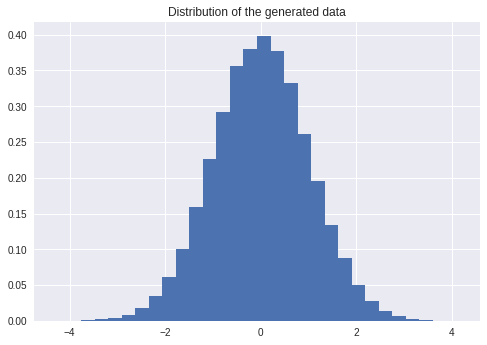

In [0]:
#@title <font size='4'> Data Generation</font> {display-mode: "form"}
#- Seed
npr.seed(1)
# Number of points
N = n_p.value
#- Distribution 
dataType = dist.value
#- Generation of points
if dataType == "Normal":
    x = npr.randn(N)
    print('Normal data simulation')
elif dataType == "Log-normal":
    x = npr.lognormal(0,1,size=N)
    print('Log-normal data simulation')
# We store the mean and std deviation for later reference, they are also the MAP and MLE estimates in this case.
realMean = np.mean(x)
realStd = np.std(x)

print('Number of points= %d'%N)
print("Mean =", np.round(realMean,4))
print ("standard deviation =", np.round(realStd,4))
# Plot of points generates
plt.hist(x, 30, normed=True)
plt.title('Distribution of the generated data')
plt.show()

In [0]:
#@title <font size='4'> Enter the number of iterations for vanilla MH:</font> {display-mode: "form"}
n_iter = widgets.IntText(
    value = 10000,
    description = 'Iterations:',
    disabled = False
)
n_iter

IntText(value=10000, description='Iterations:')

In [0]:
#@title <font size='4'> Running vanilla MH algorithm</font> {display-mode: "form"}
S = vanillaMH(n_iter.value)

#plt.figure(figsize=(15,7))
#plt.subplot(1,2,1)
#plt.plot(S[:,0],label = r"MH chain of: $\mu$")
#plt.axhline(0, color='red', label = r"$\mu = 0 $")
#plt.ylim([-0.1, 0.1])
#plt.xlabel('Iterations')
#plt.legend()
#plt.subplot(1,2,2)
#plt.plot(np.exp(S[:,0]),label = r"MH chain of: $\sigma$")
#plt.axhline(1, color='red',label = r"$\sigma = 1 $")
#plt.xlabel('Iterations')
#plt.legend()
#plt.ylim([0.90, 1.1])
#plt.show()



Iteration 0 and  Acceptance percentage 0.00 
Iteration 1000 and  Acceptance percentage 50.35 
Iteration 2000 and  Acceptance percentage 50.72 
Iteration 3000 and  Acceptance percentage 50.68 
Iteration 4000 and  Acceptance percentage 50.79 
Iteration 5000 and  Acceptance percentage 50.43 
Iteration 6000 and  Acceptance percentage 50.47 
Iteration 7000 and  Acceptance percentage 50.19 
Iteration 8000 and  Acceptance percentage 50.18 
Iteration 9000 and  Acceptance percentage 49.89 


In [0]:
#@title <font size='4'> Confidence Sampler implementation</font> {display-mode: "form"}

## Concentration bounds
def ctBernsteinSerfling(N,n,a,b,sigma,delta):
    """
    Bernstein-type bound without replacement, from (Bardenet and Maillard, to appear in Bernoulli)
    """
    l5 = np.log(5/delta)
    kappa = 7.0/3+3/np.sqrt(2)
    if n<=N/2:
        rho = 1-1.0*(n-1)/N
    else:
        rho = (1-1.0*n/N)*(1+1.0/n)
    return sigma*np.sqrt(2*rho*l5/n) + kappa*(b-a)*l5/n

def ctHoeffdingSerfling(N,n,a,b,delta):
    """
    Classical Hoeffding-type bound without replacement, from (Serfling, Annals of Stats 1974)
    """
    l2 = np.log(2/delta)
    if n<=N/2:
        rho = 1-1.0*(n-1)/N
    else:
        rho = (1-1.0*n/N)*(1+1.0/n)
    return (b-a)*np.sqrt(rho*l2/2/n)

def ctBernstein(N,n,a,b,sigma,delta):
    """
    Classical Bernstein bound, see e.g. the book by Boucheron, Lugosi, and Massart, 2014.
    """
    l3 = np.log(3/delta)
    return sigma*np.sqrt(2*l3/n) + 3*(b-a)*l3/n


## Confidence MCMC (Bardenet, Doucet, and Holmes, ICML'14)
def confidenceMCMC(T):
    
    # Initialize
    theta = np.array([realMean,np.log(realStd)])
    stepsize = .01 
    S_B = np.zeros((T,2))
    delta = .1
    acceptance = 0.0
    gamma = 1.5
    ns_B = []
    
    bs = []
    
    for i in range(T):
        
        npr.shuffle(x)
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        n = N/10
        cpt = 0
        lhds = getLogLhd(x, thetaP[0], np.exp(thetaP[1])) - getLogLhd(x, theta[0], np.exp(theta[1]))
        a = np.min(lhds)
        b = np.max(lhds)
            
        while not done and n<N:
        
            n = min(N,np.floor(gamma*n))
            cpt+=1
            deltaP = delta/2/cpt**2
            # The following step should be done differently to avoid recomputing previous likelihoods, but for the toy examples we keep it short
            lhds = getLogLhd(x[:int(n)], thetaP[0], np.exp(thetaP[1])) - getLogLhd(x[:int(n)], theta[0], np.exp(theta[1])) 
            Lambda = np.mean(lhds)
            sigma = np.std(lhds)
            psi = np.log(u)/N
            if np.abs(Lambda-psi) > ctBernstein(N,n,a,b,sigma,deltaP):
                done = 1
        bs.append(n)

        if i>1 and ns_B[-1] == 2*N:
            ns_B.append(n) # Half of the likelihoods were computed at the previous stage
        else:
            ns_B.append(2*n) # The algorithm required all likelihoods for theta and theta', next iteration we can reuse half of them
        
        if Lambda>psi:
            # Accept
            theta = thetaP
            accepted = 1
            S_B[i] = thetaP
        else:
            # Reject
            S_B[i] = theta
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))    
            
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        if np.mod(i,T/10)==0:
            # Monitor acceptance and average number of samples used
            print("Iteration", i, "Acceptance", acceptance, "Avg. num evals", np.mean(ns_B), "sigma/sqrt(n)", sigma/np.sqrt(n), "R/n", (b-a)/n)
        
    return S_B, ns_B, bs

In [0]:
#@title <font size='4'> Enter the number of iterations for Confidence Sampler:</font> {display-mode: "form"}
n_iter_conf = widgets.IntText(
    value = 10000,
    description = 'Iterations:',
    disabled = False
)
n_iter_conf

IntText(value=10000, description='Iterations:')

In [0]:
#@title <font size='4'> Running the Confidence Sampler</font> {display-mode: "form"}

S_B, ns_B, bs = confidenceMCMC(n_iter_conf.value)

Iteration 0 Acceptance 0.0 Avg. num evals 200000.0 sigma/sqrt(n) 4.395225050451293e-05 R/n 1.5390382929998826e-06
Iteration 1000 Acceptance 0.4905094905094903 Avg. num evals 148947.92507492506 sigma/sqrt(n) 2.0524631030610058e-05 R/n 5.513361838972485e-07
Iteration 2000 Acceptance 0.5237381309345327 Avg. num evals 148457.95452273864 sigma/sqrt(n) 1.221251411125473e-05 R/n 4.979166349999433e-07
Iteration 3000 Acceptance 0.5334888370543155 Avg. num evals 148237.14561812728 sigma/sqrt(n) 1.827195489979916e-05 R/n 4.948659768960084e-07
Iteration 4000 Acceptance 0.5446138465383661 Avg. num evals 148095.23619095227 sigma/sqrt(n) 3.526295495338081e-06 R/n 1.7891358035839234e-07
Iteration 5000 Acceptance 0.5406918616276746 Avg. num evals 148087.6898620276 sigma/sqrt(n) 1.0740827112220162e-05 R/n 3.9614072911498265e-07
Iteration 6000 Acceptance 0.5384102649558408 Avg. num evals 148121.50541576403 sigma/sqrt(n) 1.1200128300823346e-05 R/n 3.608274174049231e-07
Iteration 7000 Acceptance 0.53806599

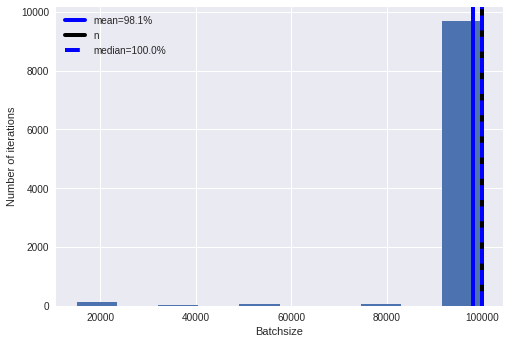

In [0]:
#@title <font size='4'> Histogram of the number of likelihood evaluations:</font> {display-mode: "form"}
plt.hist(bs)

labStr = "mean="+str(np.around(1.0*np.mean(bs)/N*100,1))+"%"
plt.axvline(np.mean(bs), linewidth = 4, color="blue", label=labStr)
plt.axvline(N, linewidth = 4, color="k", label="n") 
labStr = "median="+str(np.around(1.0*np.median(bs)/N*100,1))+"%"
plt.axvline(np.median(bs), linewidth = 4, color="blue",linestyle='--', label=labStr)
plt.legend()
plt.xlabel("Batchsize")
plt.ylabel("Number of iterations")
plt.show()

In [0]:
#@title <font size='4'> Implementation of the Improved Confidence Sampler with Taylor expansions </font> {display-mode: "form"}

def combineMeansAndSSQs(N1, mu1, ssq1, N2, mu2, ssq2):
    """
    combine means and sum of squares of two sets
    """
    dd = mu2 - mu1
    mu = mu1
    ssq = ssq1
    N = N1+N2
    mu += dd*N2/N
    ssq += ssq2
    ssq += (dd**2) * N1 * N2 / N
    return N, mu, ssq
    
### Differential functions for proxies, 

### Define vectorized evaluation of gradient and Hessian
myGradientVect = lambda x_float, mu_float, sigma_float:np.array([-(2*mu_float - 2*x_float)/(2*sigma_float**2), -1/sigma_float + (-mu_float + x_float)**2/sigma_float**3]).T
myHessianVect = lambda x_float, mu_float, sigma_float:[[-1/sigma_float**2*np.ones(x_float.shape), 2*(mu_float - x_float)/sigma_float**3], [2*(mu_float - x_float)/sigma_float**3, (1 - 3*(mu_float - x_float)**2/sigma_float**2)/sigma_float**2]]

# Compute third order derivatives to bound the Taylor remainder. Symbolic differentiation is not really necessary in this simple case, but
# it may be useful in later applications
def thirdDerivatives():
    x, mu, sigma = sym.symbols('x, mu, sigma')
    L = []
    for i in range(4):
        for j in range(4):
            if i+j == 3:
                args = tuple([-(x-mu)**2/(2*sigma**2) -sym.log(sigma)] + [mu for cpt in range(i)] + [sigma for cpt in range(j)])                
                L.append( sym.diff(*args) )
    return L
    
def evalThirdDerivatives(x_float, mu_float, logSigma_float): 
    tt = thirdDerivatives()
    return [tt[i].subs('x',x_float).subs('mu',mu_float).subs('sigma',np.exp(logSigma_float)).evalf() for i in range(4)]

# Find the MAP (not really necessary here since the MAP are the mean and std deviation of the data)
f = lambda theta: -np.mean(getLogLhd(x, theta[0], np.exp(theta[1])))
thetaMAP = spo.minimize(f, np.array([realMean, np.log(realStd)])).x

### Confidence MCMC with proxy (Bardenet, Doucet, and Holmes, this submission)
def confidenceMCMCWithProxy(T):
    
    npr.seed(1)
    # Initialize
    theta = np.array([realMean,np.log(realStd)])
    stepsize = .01 
    S_B = np.zeros((T,2))
    delta = .1
    acceptance = 0.0
    gamma = 2.
    ns_B = []
    
    # Compute some statistics of the data that will be useful for bounding the error and averaging the proxies    
    minx = np.min(x)
    maxx = np.max(x)
    meanx = np.mean(x)
    meanxSquared = np.mean(x**2)
    
    # Prepare total sum of Taylor proxys
    muMAP = thetaMAP[0]
    sigmaMAP = np.exp(thetaMAP[1])
    meanGradMAP = np.array( [(meanx - muMAP)/sigmaMAP**2, (meanxSquared-2*muMAP*meanx+muMAP**2)/sigmaMAP**3 - 1./sigmaMAP] )
    meanHessMAP = np.array( [[-1./sigmaMAP**2, -2*(meanx-muMAP)/sigmaMAP**3], [-2*(meanx-muMAP)/sigmaMAP**3, -3*(meanxSquared-2*muMAP*meanx+muMAP**2)/sigmaMAP**4 + 1/sigmaMAP**2]] )    
    
    bs = []
    
    for i in range(T):
        
        npr.shuffle(x)
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        n = 2
        t0 = 0
        cpt = 0
        Lambda = 0
        ssq = 0 # Sum of squares
        
        # Prepare Taylor bounds
        xMinusMuMax = np.max(np.abs([1, minx-theta[0], maxx-theta[0], minx-thetaMAP[0], maxx-thetaMAP[0], minx-thetaP[0], maxx-thetaP[0]]))
        sigmaMin = np.min(np.exp([theta[1], thetaMAP[1], thetaP[1]]))
        R = float(np.max(np.abs(evalThirdDerivatives(xMinusMuMax, 0, np.log(sigmaMin)))))
        h = np.array([theta[0]-thetaMAP[0], np.exp(theta[1])-np.exp(thetaMAP[1])])
        hP = np.array([thetaP[0]-thetaMAP[0], np.exp(thetaP[1])-np.exp(thetaMAP[1])])
        R *= 2*1./6 * max(np.sum(np.abs(h)), np.sum(np.abs(hP)))**3
        a = -R
        b = R
        
        # We can already compute the average proxy log likelihood ratio
        avgTotalProxy = np.dot(meanGradMAP, hP-h) + .5*np.dot( hP-h, np.dot(meanHessMAP, h+hP) ) 
        
        while not done and n<N:
        
            n = min(N,np.floor(gamma*n))
            cpt+=1
            deltaP = delta/2/cpt**2
            batch = x[int(t0):int(n)]
            lhds = getLogLhd(batch, thetaP[0], np.exp(thetaP[1])) - getLogLhd(batch, theta[0], np.exp(theta[1]))
            proxys = np.dot(myGradientVect(batch, muMAP, sigmaMAP), hP-h) + 0.5*np.dot(np.dot(hP-h, myHessianVect(batch,muMAP,sigmaMAP)).T, h+hP)
            if np.any(np.abs(lhds-proxys)>R):
                # Just a check that our error is correctly bounded
                print("Taylor remainder is underestimated")
            tmp, Lambda, ssq = combineMeansAndSSQs(t0, Lambda, ssq, n-t0, np.mean(lhds-proxys), (n-t0)*np.var(lhds-proxys))
            sigma = np.sqrt(1./n*ssq)
            psi = np.log(u)/N
            t0 = n
            if np.abs(Lambda-psi + avgTotalProxy) > ctBernstein(N,n,a,b,sigma,deltaP):
                done = 1
        bs.append(n)
        
        if i>1 and ns_B[-1] == 2*N:
            ns_B.append(n) # Half of the likelihoods were computed at the previous stage
        else:
            ns_B.append(2*n)
            
        if Lambda+avgTotalProxy>psi:
            # Accept
            theta = thetaP
            accepted = 1
            S_B[i] = thetaP
        else:
            # Reject
            S_B[i] = theta
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))    
        
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        if np.mod(i,T/10)==0:
            # Monitor acceptance and average number of samples used
            print("Iteration", i, "Acceptance", acceptance, "Avg. num samples", np.mean(ns_B), "Dist. to MAP", np.sum( np.abs(theta-thetaMAP) ), "sigma/sqrt(n)", sigma/np.sqrt(n), "R/n", R/n)
        
    return S_B, ns_B, bs

In [0]:
#@title <font size='4'> Running the Improved Confidence Sampler</font> {display-mode: "form"}

S_BP, ns_BP, bs2 = confidenceMCMCWithProxy(10000)

Iteration 0 Acceptance 0.0 Avg. num samples 1024.0 Dist. to MAP 0.0 sigma/sqrt(n) 3.1026756854543736e-09 R/n 6.472474098772885e-08
Iteration 1000 Acceptance 0.49850149850149844 Avg. num samples 859.7082917082917 Dist. to MAP 0.0002493180558642231 sigma/sqrt(n) 4.594563220871523e-11 R/n 5.055738236017883e-08
Iteration 2000 Acceptance 0.5072463768115952 Avg. num samples 954.5347326336831 Dist. to MAP 0.0061598892790331004 sigma/sqrt(n) 5.239127046418569e-09 R/n 3.4652091675663985e-08
Iteration 3000 Acceptance 0.501166277907365 Avg. num samples 941.1449516827724 Dist. to MAP 0.010949986805270207 sigma/sqrt(n) 4.188643171210579e-08 R/n 1.8371592178874226e-07
Iteration 4000 Acceptance 0.49337665583604184 Avg. num samples 960.5618595351162 Dist. to MAP 0.0029151686946896163 sigma/sqrt(n) 2.1925098484149743e-08 R/n 1.9431378819589596e-07
Iteration 5000 Acceptance 0.49610077984403195 Avg. num samples 1092.4599080183964 Dist. to MAP 0.0010866662283205996 sigma/sqrt(n) 2.6516201557106773e-08 R/n

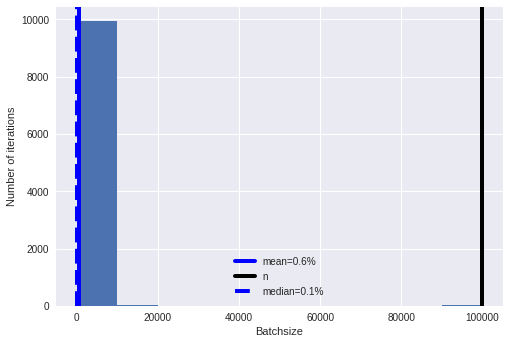

In [0]:
#@title <font size='4'> Histogram of the number of likelihood evaluations:</font> {display-mode: "form"}
plt.hist(bs2)

labStr = "mean="+str(np.around(1.0*np.mean(bs2)/N*100,1))+"%"
plt.axvline(np.mean(bs2), linewidth = 4, color="blue", label=labStr)
plt.axvline(N, linewidth = 4, color="k", label="n") 
labStr = "median="+str(np.around(1.0*np.median(bs2)/N*100,1))+"%"
plt.axvline(np.median(bs2), linewidth = 4, color="blue",linestyle='--', label=labStr)
plt.legend()
plt.xlabel("Batchsize")
plt.ylabel("Number of iterations")
plt.show()